# Looking at shutdown periods

I suspect that there is some strong non-linearity in the shutdown periods and linearity in the operation periods. Let's take a closer look to see if this is indeed the case. 

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data
df=pd.read_parquet('/home/keepfloyding/KraftHack/input_dataset-2.parquet')

# Make operation a bool
df['mode']=df['mode']=='operation'

# Select subset
#df=df.sample(100000)

# Remove nans
df = df.dropna()

print(df.shape)

df.head()

(943931, 22)


,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode,Bolt_1_Steel tmp,Bolt_1_Tensile,Bolt_2_Tensile,...,Bolt_5_Tensile,Bolt_6_Tensile,Bolt_1_Torsion,Bolt_2_Torsion,Bolt_3_Torsion,Bolt_4_Torsion,Bolt_5_Torsion,Bolt_6_Torsion,lower_bearing_vib_vrt,turbine_bearing_vib_vrt
timepoints,,,,,,,,,,,,,,,,,,,,,
1970-12-29 10:59:57,311.093257,4.949223,94.206187,150.827828,5305.873472,108.033198,True,2.458908,1609.140569,1488.522739,...,1637.373796,1678.107726,177.730733,163.324591,146.500052,226.013417,298.403158,161.914265,0.154292,0.517703
1970-12-29 10:59:58,311.103996,5.051777,94.206457,150.774664,5305.690188,108.033197,True,2.458729,1609.127944,1488.494639,...,1637.353554,1678.100380,177.736039,163.323607,146.498639,226.013106,298.403272,161.912569,0.155838,0.530280
1970-12-29 10:59:59,311.114735,5.154330,94.206726,150.559452,5305.466701,108.033196,True,2.459334,1609.138758,1488.493451,...,1637.360655,1678.106863,177.735616,163.328645,146.494156,226.013736,298.397846,161.912716,0.169547,0.540085
1970-12-29 11:00:00,311.125475,5.256883,94.206995,150.344239,5305.243213,108.033195,True,2.459329,1609.121478,1488.488279,...,1637.365372,1678.078172,177.738552,163.331201,146.491341,226.017247,298.400658,161.912572,0.173561,0.526994
1970-12-29 11:00:01,311.136214,5.359436,94.207264,150.129027,5305.019725,108.033194,True,2.459337,1609.113766,1488.488892,...,1637.354723,1678.067193,177.741082,163.329769,146.498284,226.013418,298.402517,161.915946,0.166955,0.524617


In [67]:
# Around 0.4% contains shutdown periods for data set 1
df['mode'].value_counts(normalize=True)

True     0.995786
False    0.004214
Name: mode, dtype: float64

In [68]:
# Checking df_input to see how important it is
df_input=pd.read_parquet('/home/keepfloyding/KraftHack/prediction_input.parquet')

# Even less, it's around 0.2%
df_input['mode'].value_counts(normalize=True)

operation    0.997478
start        0.002522
Name: mode, dtype: float64

## Idenitfy if start-up regions are weak performers



In [69]:
# Let's see how linear model performs in these regions
# Split into input and target variables
X = df[['Unit_4_Power', 'Unit_4_Reactive Power', 'Turbine_Guide Vane Opening',
       'Turbine_Pressure Drafttube', 'Turbine_Pressure Spiral Casing',
       'Turbine_Rotational Speed', 'mode']]

y = df.filter(regex='Bolt_1_Tensile')

# Split data set into test and train
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y)



In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error


# Scale
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_train)

# Train
model = LinearRegression()
model.fit(X_scale, y_train)

# Perform a prediction
y_pred = model.predict(scaler.transform(X_test))

# Check the score
res = mean_absolute_percentage_error(y_test,y_pred)
print(res)

y_1 = y_pred.reshape(y_test.shape[0])
y_2 = y_test['Bolt_1_Tensile'].values


0.0023906189543782103


In [71]:
tmp = X_test.reset_index()
off_vals = tmp[~ tmp['mode']].index

mean_absolute_percentage_error(y_2[off_vals],y_1[off_vals])

0.007276667684808386

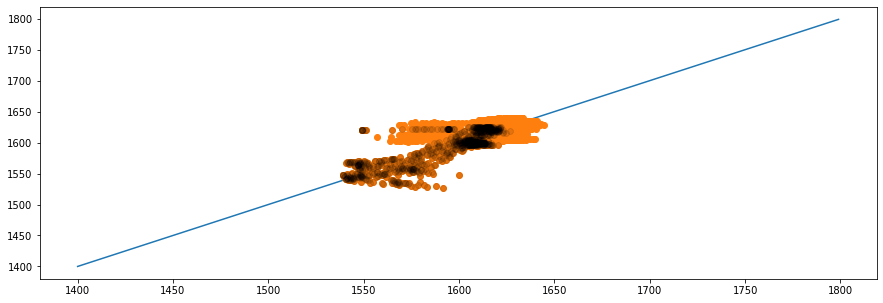

In [72]:
# Despite a weaker overal performance, there are multiple regions within operation mode that indicate non-linearity

plt.figure(figsize=(15,5))
plt.plot(range(1400,1800),range(1400,1800))
plt.plot(y_1,y_2,'o')
plt.plot(y_1[off_vals],y_2[off_vals],'ok',alpha=0.1)

In [73]:
# Is this still the case with Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

# Scale
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_train)

# Train
model = RandomForestRegressor(n_estimators=10)
model.fit(X_scale, y_train)

# Perform a prediction
y_pred = model.predict(scaler.transform(X_test))

# Check the score
res = mean_absolute_percentage_error(y_test,y_pred)
print(res)

y_1 = y_pred.reshape(y_test.shape[0])
y_2 = y_test['Bolt_1_Tensile'].values

/tmp/ipykernel_75095/842243045.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_scale, y_train)


4.010693053630471e-05


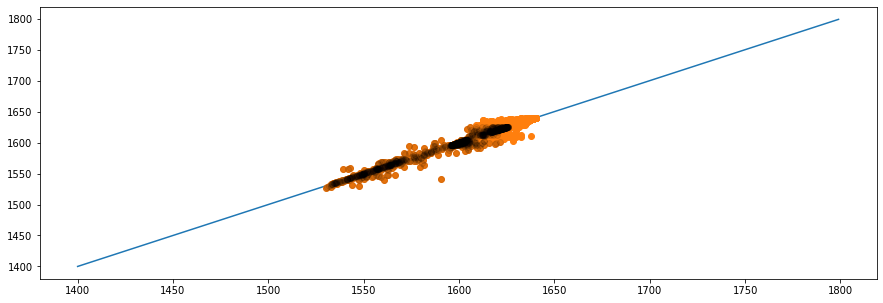

In [74]:
# Despite a weaker overal performance, there are multiple regions within operation mode that indicate non-linearity

plt.figure(figsize=(15,5))
plt.plot(range(1400,1800),range(1400,1800))
plt.plot(y_1,y_2,'o')
plt.plot(y_1[off_vals],y_2[off_vals],'ok',alpha=0.1)

In [75]:
# Problem still holds for non-linear models; so there could be some saving here
tmp = X_test.reset_index()
off_vals = tmp[~ tmp['mode']].index

mean_absolute_percentage_error(y_2[off_vals],y_1[off_vals])

0.0014985064679734889

In [76]:
# Some saving can be done here
mean_absolute_percentage_error(y_2[list(set(tmp.index)-set(off_vals))],y_1[list(set(tmp.index)-set(off_vals))])

3.4093717911624354e-05

## Individual model for shutdown periods

Let's see if we can solve the problem with individual models

In [83]:
tmp = X.reset_index()
off_vals = tmp[~ tmp['mode']].index

X_train, X_test, y_train, y_test = train_test_split(X.iloc[off_vals].drop('mode',axis=1),y.iloc[off_vals])

In [84]:
X_train.shape

(2983, 6)

In [85]:
# Scale
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_train)

# Train
#model = LinearRegression()
model = RandomForestRegressor(n_estimators=10)
model.fit(X_scale, y_train)

# Perform a prediction
y_pred = model.predict(scaler.transform(X_test))

# Check the score
res = mean_absolute_percentage_error(y_test,y_pred)
print(res)

y_1 = y_pred.reshape(y_test.shape[0])
y_2 = y_test['Bolt_1_Tensile'].values


0.0014866617333083435


/tmp/ipykernel_75095/1642497641.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_scale, y_train)


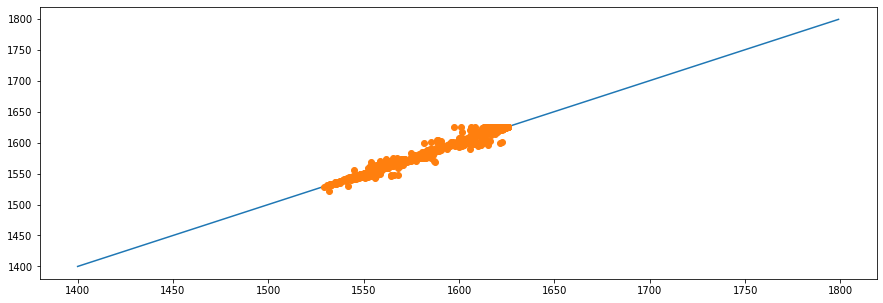

In [86]:
# No change in score, which might indicate that the issue we are having is with point outliers in the data set?
# How do we improve the prediction of start-up periods? - there might be a feature that we simply aren't capturing; or the data is not so good?

plt.figure(figsize=(15,5))
plt.plot(range(1400,1800),range(1400,1800))
plt.plot(y_1,y_2,'o')


## Looking at low power regions



309.6368551004313


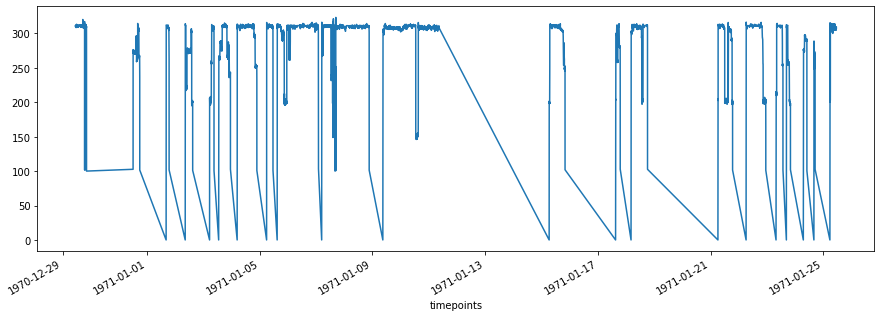

In [93]:
df['Unit_4_Power'].plot(figsize=(15,5))
print(df['Unit_4_Power'].median())

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [109]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error


# Scale
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_train)

# Train
model = LinearRegression()
model.fit(X_scale, y_train)

# Perform a prediction
y_pred = model.predict(scaler.transform(X_test))

# Check the score
res = mean_absolute_percentage_error(y_test,y_pred)
print(res)

y_1 = y_pred.reshape(y_test.shape[0])
y_2 = y_test['Bolt_1_Tensile'].values


0.0023908423716148867


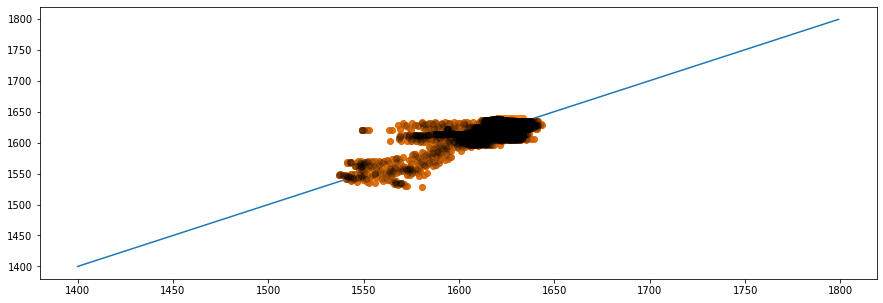

In [110]:
# Do low power states have bad performance

tmp = X_test.reset_index()
off_vals = tmp[tmp['Unit_4_Power']<300].index

plt.figure(figsize=(15,5))
plt.plot(range(1400,1800),range(1400,1800))
plt.plot(y_1,y_2,'o')
plt.plot(y_1[off_vals],y_2[off_vals],'ok',alpha=0.1)

In [111]:
#Do low power states have bad performance

mean_absolute_percentage_error(y_2[off_vals],y_1[off_vals])

# Looks like they do!!! What about for forest?

0.004009720286979684

In [106]:


# Scale
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_train)

# Train
model = RandomForestRegressor(n_estimators=10)
model.fit(X_scale, y_train)

# Perform a prediction
y_pred = model.predict(scaler.transform(X_test))

# Check the score
res = mean_absolute_percentage_error(y_test,y_pred)
print(res)

y_1 = y_pred.reshape(y_test.shape[0])
y_2 = y_test['Bolt_1_Tensile'].values


/tmp/ipykernel_75095/198762214.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_scale, y_train)


4.017931589653934e-05


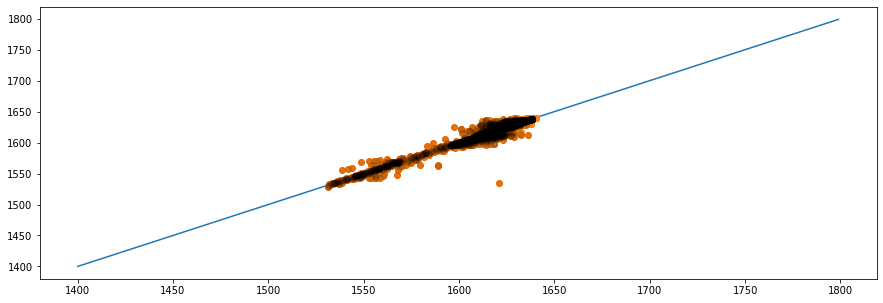

In [107]:
# Do low power states have bad performance

tmp = X_test.reset_index()
off_vals = tmp[tmp['Unit_4_Power']<300].index

plt.figure(figsize=(15,5))
plt.plot(range(1400,1800),range(1400,1800))
plt.plot(y_1,y_2,'o')
plt.plot(y_1[off_vals],y_2[off_vals],'ok',alpha=0.1)

In [108]:
mean_absolute_percentage_error(y_2[off_vals],y_1[off_vals])



0.0001218301807711679

In [112]:
print(len(off_vals))

47529


## Individual models on low power states? 

In [113]:
tmp = X.reset_index()
off_vals = tmp[tmp['Unit_4_Power']<300].index

X_train, X_test, y_train, y_test = train_test_split(X.iloc[off_vals].drop('mode',axis=1),y.iloc[off_vals])

In [114]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error


# Scale
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_train)

# Train
model = LinearRegression()
model.fit(X_scale, y_train)

# Perform a prediction
y_pred = model.predict(scaler.transform(X_test))

# Check the score
res = mean_absolute_percentage_error(y_test,y_pred)
print(res)

y_1 = y_pred.reshape(y_test.shape[0])
y_2 = y_test['Bolt_1_Tensile'].values


0.004435923558668771


In [115]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error


# Scale
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_train)

# Train
model = RandomForestRegressor()
model.fit(X_scale, y_train)

# Perform a prediction
y_pred = model.predict(scaler.transform(X_test))

# Check the score
res = mean_absolute_percentage_error(y_test,y_pred)
print(res)

y_1 = y_pred.reshape(y_test.shape[0])
y_2 = y_test['Bolt_1_Tensile'].values

/tmp/ipykernel_75095/1521371006.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_scale, y_train)


0.00010334648474455156
